<h2 style = "color: chocolate">Ayudantía N°7: Conglomerados</h2>

---

<p>Ayudante: Diego Bernal</p><b>
<p>Fuentes: <a href = "https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering">Clustering</a></p>
<p><a href = "https://stanford.edu/~cpiech/cs221/handouts/kmeans.html">K-means</a></p>
<p><a href = "https://github.com/mlfoundations/open_clip">OpenClip</a></p>

El termino clustering se refiere a las tecnicas para hallar subgrupos o conglomerados en un set de datos. Buscamos particionar la data en distintos grupos con el fin de que cada grupo contenga datos similares entre ellos, mientras que con los otros grupos son diferentes.

Para lograr esto primer debemos establecer el criterio para definir que es que sean *similares* o *diferentes* esto varia del contexto del problema que busquemos resolver.

En particular el cljustering busca encontrar subgrupos homogeneos entre las observaciones.

En la ayudantía de hoy veremos *k-means* y *clustering jerarquico*, en el primero buscamos particionar la data en *k* clases mientras que en el jerarquico partimos de la base que no conocemos en cuantaas clases lo dividiremos, para visualizarlo utilizaremos un *dendograma*.

# K-means

Entonces podemos definir lo siguiente dado un conjunto de observaciones $x^{(1)}, x^{(2)}, \dots , x^{(n)} \in \mathbb{R}^{p}$ particionamos en K clusters $C_1, C_2, \dots, C_K$ que satisfagan.

- $C_1 \cup C_2 \cup \dots \cup C_K = \{1, 2, \dots, n\}$ Cada observación pertenece al menoos a un cluster.
- $ C_k \cap C_{k'} = \emptyset \ \text{para} \  k \neq k' $ los clusters no se superponen.

El objetivo es minimizar la **variación intra-cluster total**:

$$
\min_{C_1, \dots, C_K} \left\{ \sum_{k=1}^{K} W(C_k) \right\}
$$

Donde la variación dentro del cluster se definie como:

$$
\begin{align}
W(C_k) = \frac{1}{|C_k|} \sum_{i, i' \in C_k} \sum_{j=1}^{p} (x_{ij} - x_{i'j})^2 \\
W(C_k) = \sum_{i \in C_k} \sum_{j=1}^{p} (x_{ij} - \bar{x}_{kj})^2
\end{align} 
$$

donde $\bar{x}_{kj}$ es la media de la *feature* $j$ en el cluster $C_K$.


### Entrada:
- Datos: ${\{ x^{(1)}, x^{(2)}, \dots, x^{(n)} \} \subset \mathbb{R}^p}$
- Número de clusters: $K$

### Salida:
- Etiquetas de cluster para cada observación: $ c^{(i)} \in \{1, ..., K\}$
- Centroides de cluster: $\mu_1, \mu_2, ..., \mu_K$

```plaintext
1. Inicialización:
   - Asignar aleatoriamente un número de 1 a K a cada observación.
   - Estos números representan asignaciones iniciales de clusters.

2. Repetir hasta que las asignaciones no cambien (convergencia):

   a. Para cada cluster k = 1 hasta K:
      - Calcular el centroide μ_k como el promedio de las observaciones asignadas a ese cluster.

   b. Para cada observación i = 1 hasta n:
      - Asignar x^(i) al cluster cuyo centroide esté más cercano:
        c^(i) := argmin_j || x^(i) - μ_j ||²



# Clustering jerarquico

El objetivo es agrupar observaciones de forma jerárquica, fusionando las más similares hasta formar un único grupo que contenga a todas.

```plaintext
1. Comenzar con n observaciones y una medida de disimilitud(Dist euclideana)(Complete, Single, Avarage, Centroid).
   - Tratar cada observación como su propio cluster.

2. Repetir para i = n, n - 1, ..., 2:
   a. Examinar todas las disimilitudes entre los clusters actuales.
   b. Fusionar los dos clusters más similares.
   c. Calcular la nueva disimilitud entre el nuevo cluster y los demás.



Utilizaremos el mismo set de datos de gatos para agruparlos en grupos y ver las clases que se forman para cada imagen.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("borhanitrash/cat-dataset")

print("Path to dataset files:", path)

In [88]:
import os
from PIL import Image
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.spatial import Voronoi, voronoi_plot_2d
import torch
import torchvision.transforms as transforms
from scipy.cluster.hierarchy import dendrogram
import open_clip
from sklearn.metrics import silhouette_score,silhouette_samples
import matplotlib.cm as cm
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

In [7]:
img_dir = "./imgs/cats/Data/"

In [4]:
img_height, img_width = 224, 224
channels = 3

In [111]:
#Embeddings pasar la imagen a un vector numerico
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model = model.to(device).eval()

In [112]:
image_files = sorted([f for f in os.listdir(img_dir) if f.endswith(".png")])
embeddings = []
original_images = []

In [113]:
for file in tqdm(image_files[:3000]):
    try:
        img_path = os.path.join(img_dir, file)
        image = Image.open(img_path).convert("RGB")
        original_images.append(image)

        image_input = preprocess(image).unsqueeze(0).to(device) #aplicamos el embedding
        with torch.no_grad():
            image_features = model.encode_image(image_input)
        embeddings.append(image_features.cpu().numpy().flatten()) #vector con las caracteristicas

    except Exception as e:
        print(f"Error loading {file}: {e}")



100%|██████████| 3000/3000 [04:13<00:00, 11.83it/s]


In [118]:
query = "gato con cono"
text_tokens = open_clip.tokenize([query]).to(device)

In [119]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features = text_features.cpu().numpy()

In [120]:
image_matrix = np.vstack(embeddings)  
similarities = cosine_similarity(text_features, image_matrix)[0]

In [121]:
top_k = 5
top_indices = np.argsort(similarities)[::-1][:top_k]

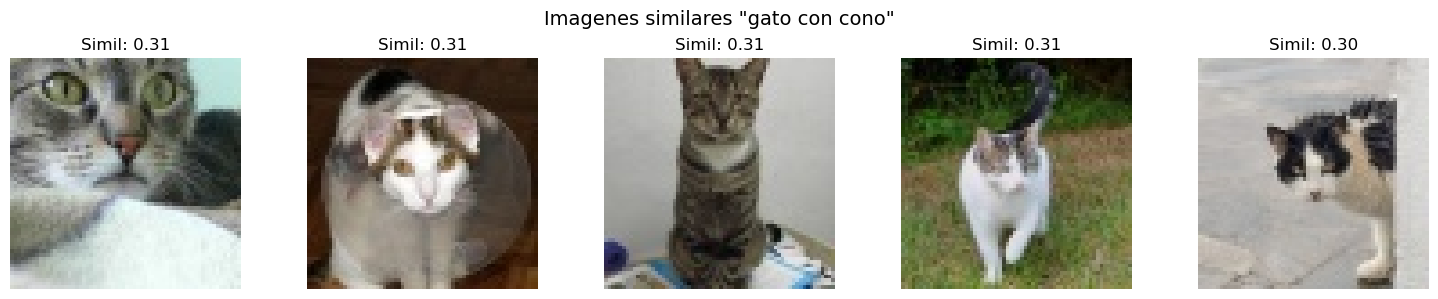

In [122]:
fig, axs = plt.subplots(1, top_k, figsize=(15, 3))
for i, idx in enumerate(top_indices):
    axs[i].imshow(original_images[idx])
    axs[i].set_title(f"Simil: {similarities[idx]:.2f}")
    axs[i].axis("off")

plt.suptitle(f"Imagenes similares \"{query}\"", fontsize=14)
plt.tight_layout()
plt.show()

In [123]:
X = np.vstack(embeddings)

In [124]:
pca = PCA()
X_pca = pca.fit_transform(X)

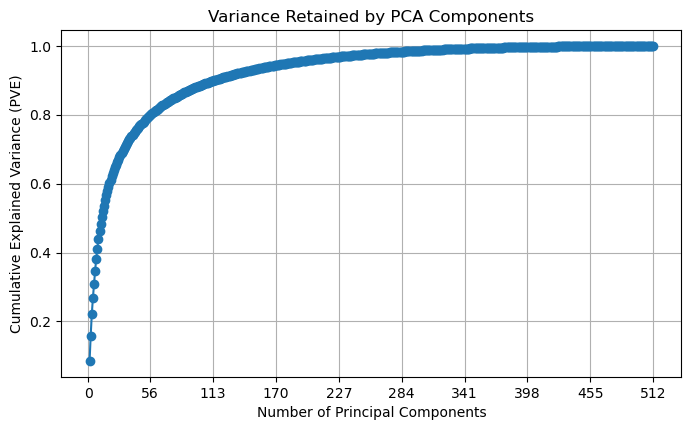

In [125]:
pve_list = np.cumsum(pca.explained_variance_ratio_)
fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
x_vals = np.arange(1, len(pve_list) + 1)
ax.plot(x_vals, pve_list, marker='o')
ax.set_xticks(np.linspace(0, len(pve_list), 10, dtype=int))
ax.set_title('Variance Retained by PCA Components')
ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('Cumulative Explained Variance (PVE)')
ax.grid(True)
plt.show()


In [126]:
def min_var(v, exp_var):
    acc = 0
    i = 0
    while acc < v:
        acc += exp_var[i]
        i += 1
    return i

min_var(0.99,pca.explained_variance_ratio_)

324

In [127]:
pca = PCA(n_components=324)
X_pca = pca.fit_transform(X)
X_pca_2d = X_pca[:, :2]

c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Para k = 2, Silhouette promedio = 0.3681


c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Para k = 3, Silhouette promedio = 0.3923


c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Para k = 4, Silhouette promedio = 0.3820


c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Para k = 5, Silhouette promedio = 0.3552


c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Para k = 6, Silhouette promedio = 0.3586


c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Para k = 8, Silhouette promedio = 0.3408


c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Para k = 10, Silhouette promedio = 0.3373


c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Para k = 12, Silhouette promedio = 0.3393


c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Para k = 14, Silhouette promedio = 0.3301


c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Para k = 15, Silhouette promedio = 0.3369


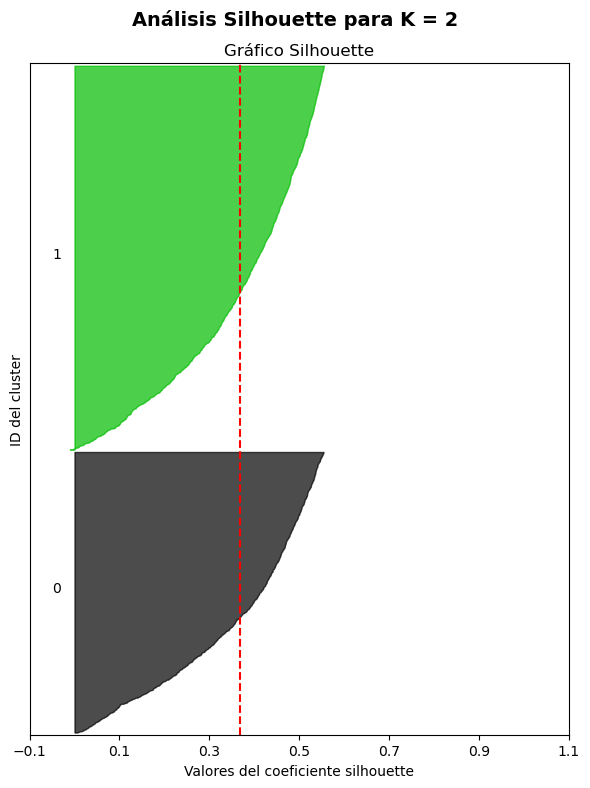

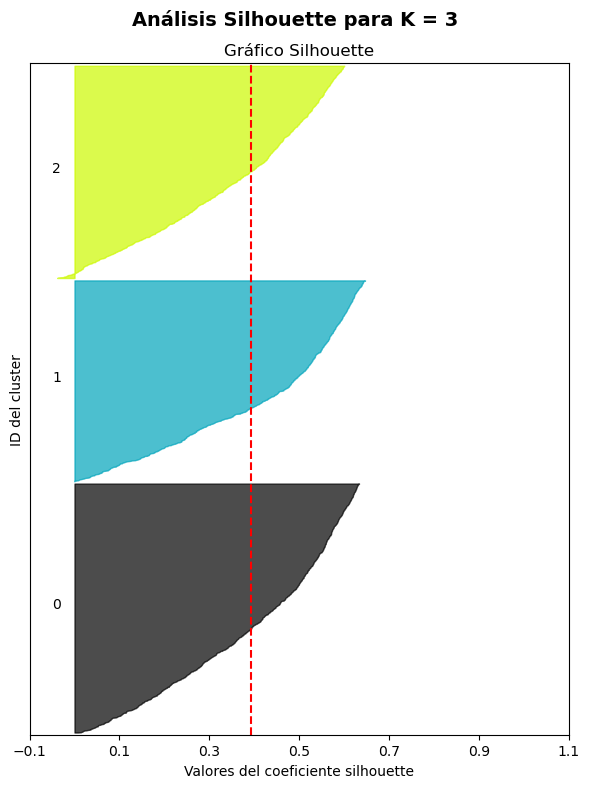

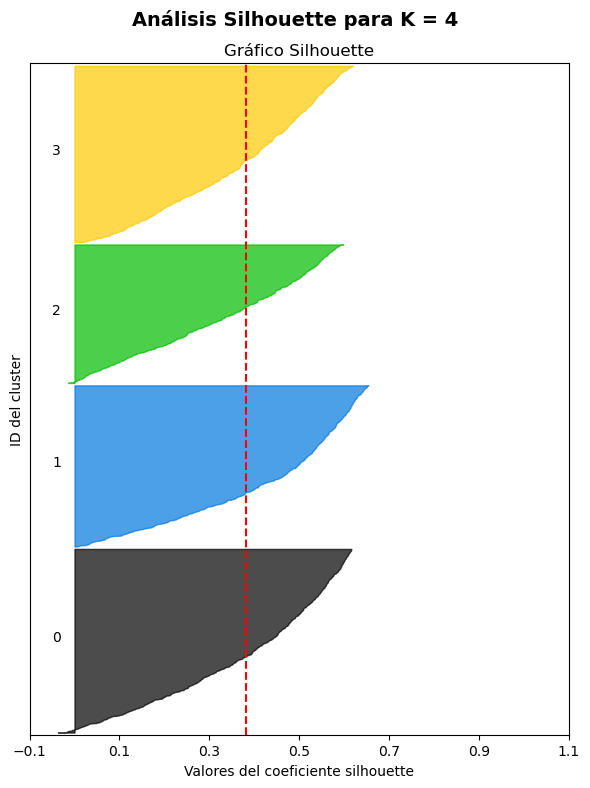

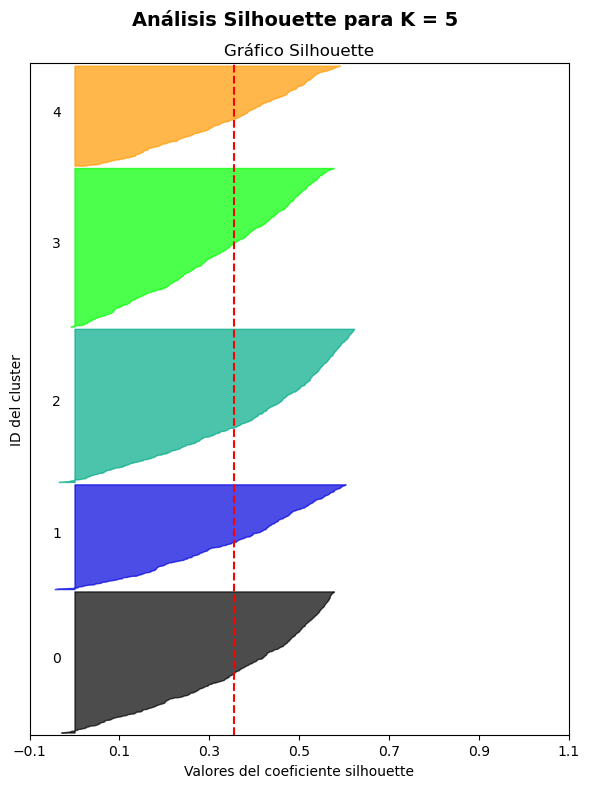

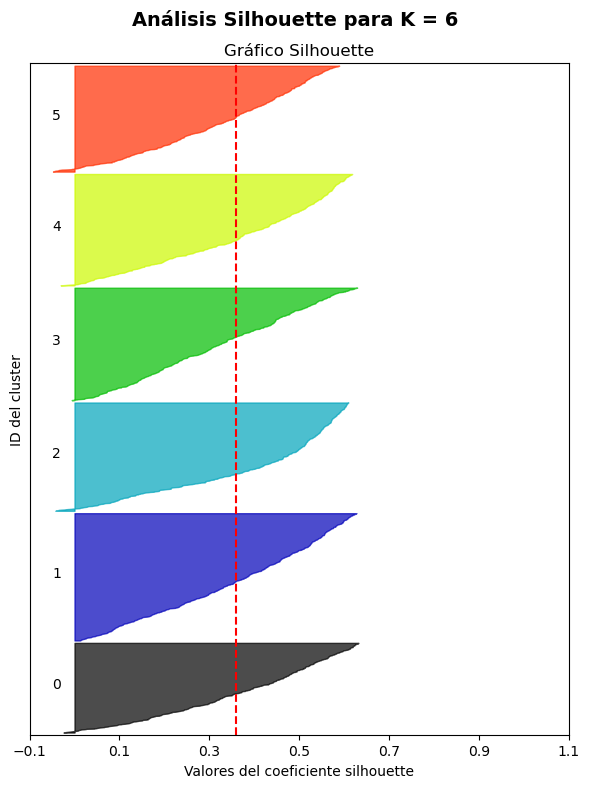

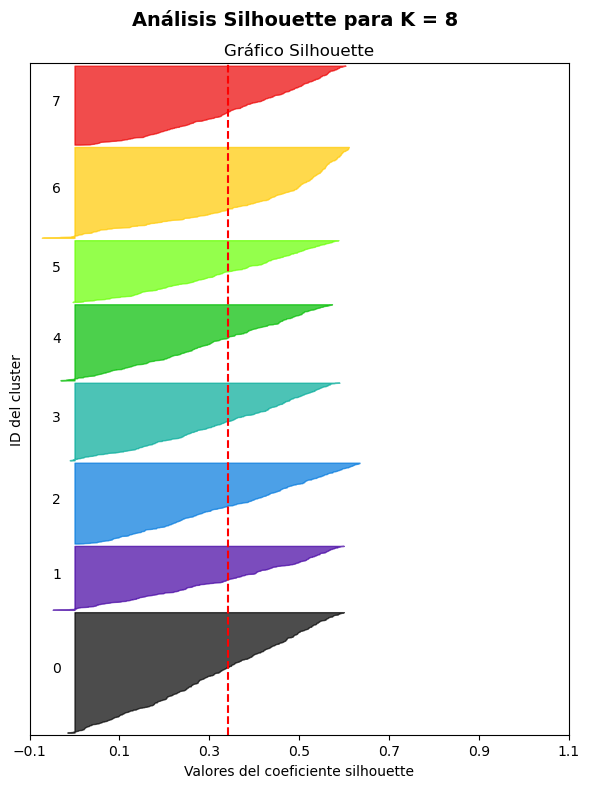

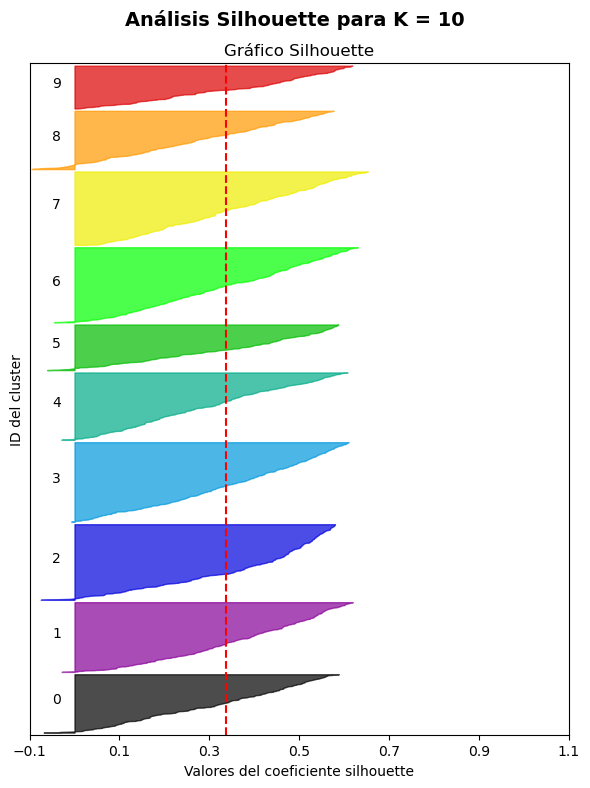

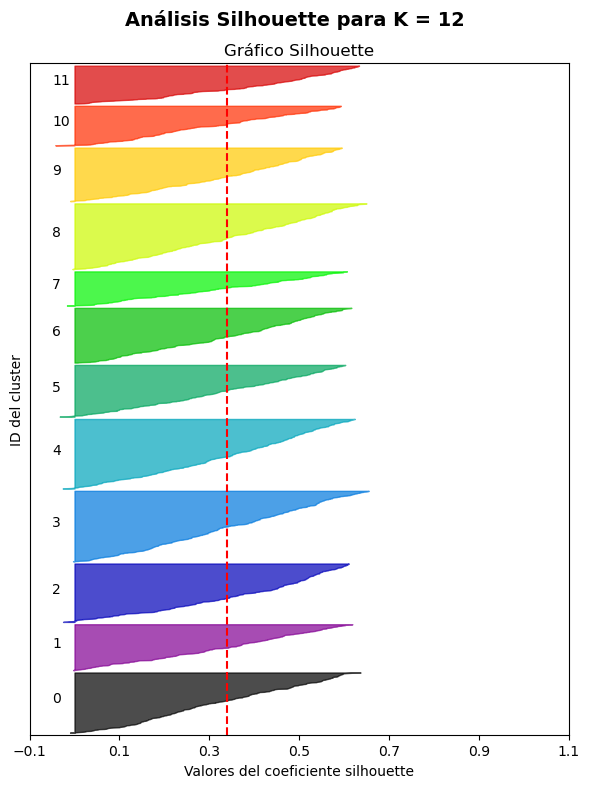

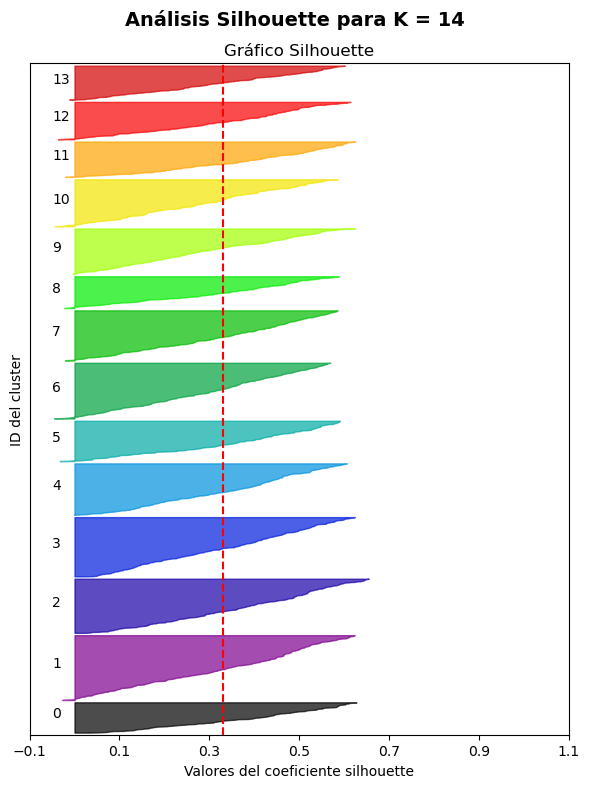

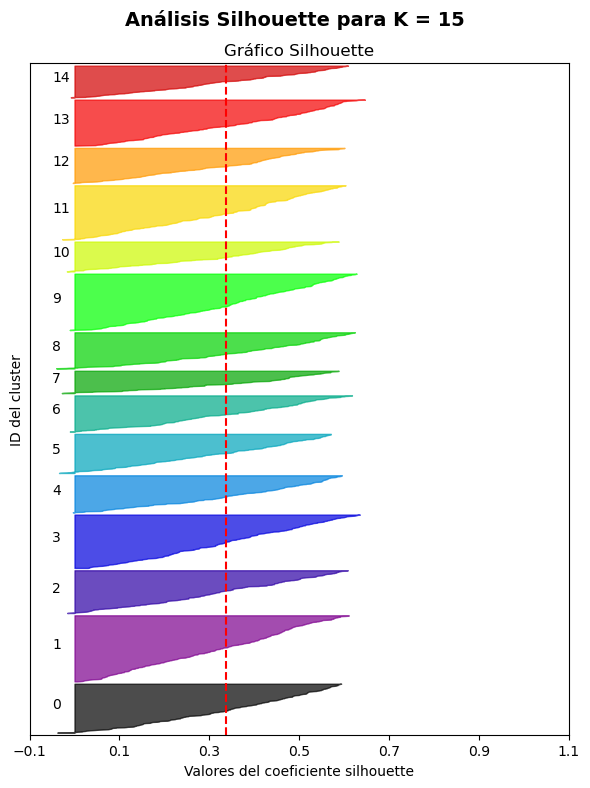

In [128]:
range_n_clusters = [2, 3, 4, 5, 6, 8, 10,12,14,15]
sil = []

for n_clusters in range_n_clusters:
    fig, ax = plt.subplots(figsize=(6, 8))
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X_pca_2d) + (n_clusters + 1) * 10])

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_pca_2d)

    silhouette_avg = silhouette_score(X_pca_2d, cluster_labels)
    sil.append(silhouette_avg)

    print(f"Para k = {n_clusters}, Silhouette promedio = {silhouette_avg:.4f}")

    sample_silhouette_values = silhouette_samples(X_pca_2d, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax.set_title("Gráfico Silhouette")
    ax.set_xlabel("Valores del coeficiente silhouette")
    ax.set_ylabel("ID del cluster")

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])
    ax.set_xticks(np.arange(-0.1, 1.1, 0.2))

    plt.suptitle(f"Análisis Silhouette para K = {n_clusters}", fontsize=14, fontweight="bold")
    plt.tight_layout()

plt.show()

c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

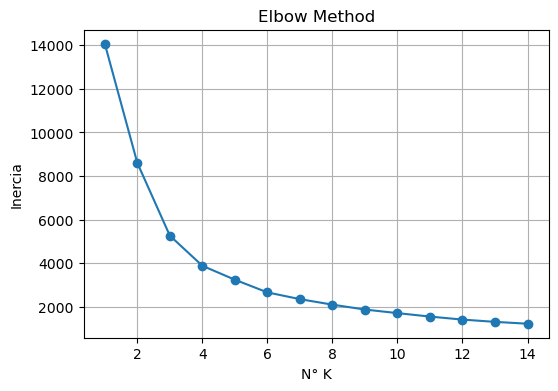

In [129]:
inertias = []
K_range = range(1, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca_2d) 
    inertias.append(kmeans.inertia_)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(K_range, inertias, marker='o')
ax.set_title('Elbow Method')
ax.set_xlabel('N° K');ax.set_ylabel('Inercia')
ax.grid(True)
plt.show()

In [130]:
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_pca_2d)
centroids = kmeans.cluster_centers_

c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [131]:
vor = Voronoi(centroids)

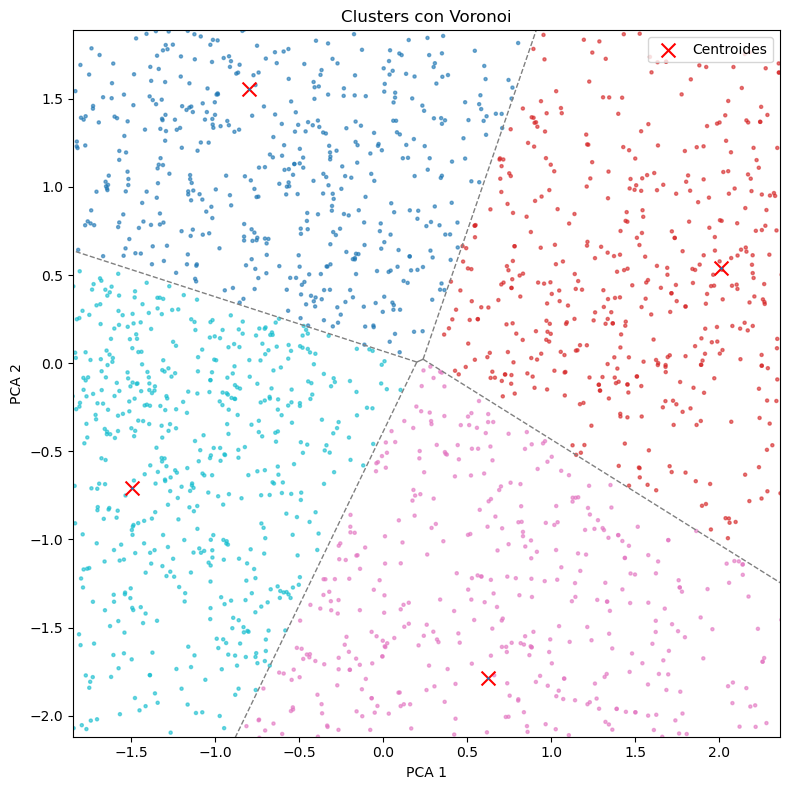

In [132]:
fig, ax = plt.subplots(figsize=(8, 8))
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='gray', line_width=1, point_size=2)
ax.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=labels, cmap='tab10', alpha=0.6, s=5)
ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='red', s=100, label='Centroides')
ax.set_title('Clusters con Voronoi')
ax.set_xlabel('PCA 1');ax.set_ylabel('PCA 2')
ax.legend()
plt.tight_layout()
plt.show()

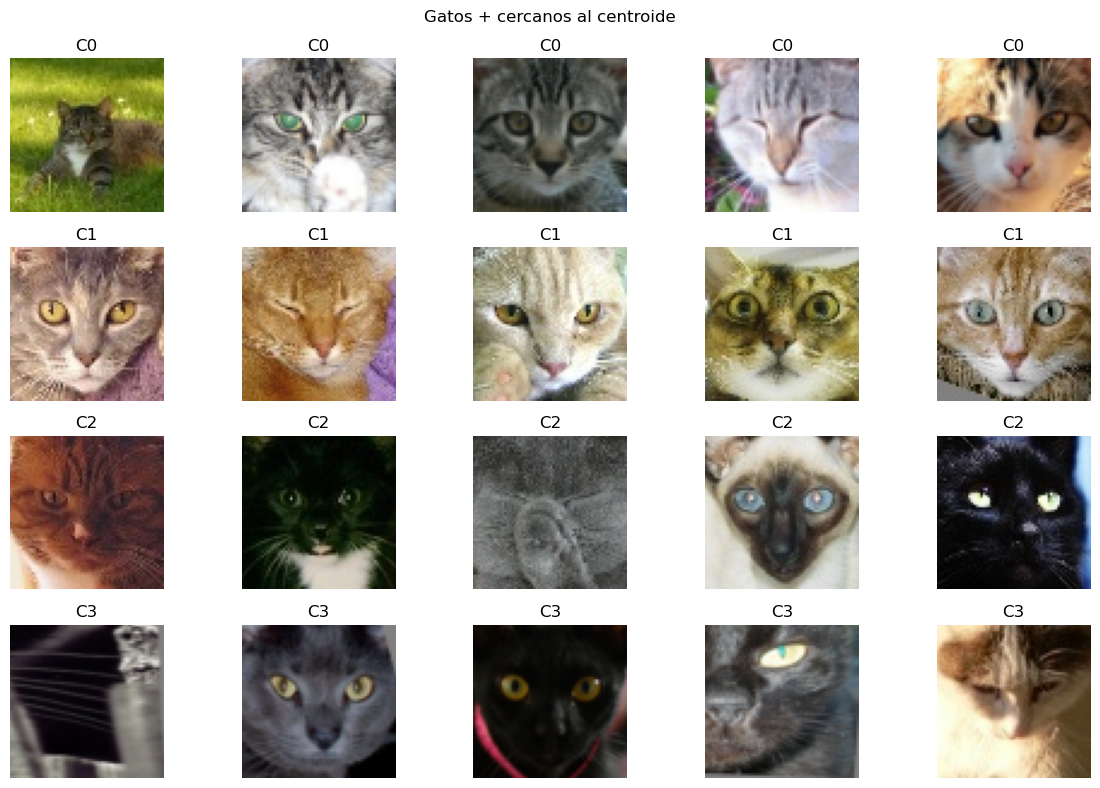

In [133]:
fig, axs = plt.subplots(4, 5, figsize=(12, 2*4))
axs = axs.reshape(4, 5)

for cluster_id in range(4):
    idxs = np.where(labels == cluster_id)[0]
    vectors = X_pca_2d[idxs]  
    center = kmeans.cluster_centers_[cluster_id].reshape(1, -1)
    
    
    distances = euclidean_distances(vectors, center).flatten()
    sorted_idxs = idxs[np.argsort(distances)]

    for j, img_idx in enumerate(sorted_idxs[:5]):
        axs[cluster_id, j].imshow(original_images[img_idx])
        axs[cluster_id, j].axis('off')
        axs[cluster_id, j].set_title(f"C{cluster_id}")

plt.suptitle("Gatos + cercanos al centroide")
plt.tight_layout()
plt.show()

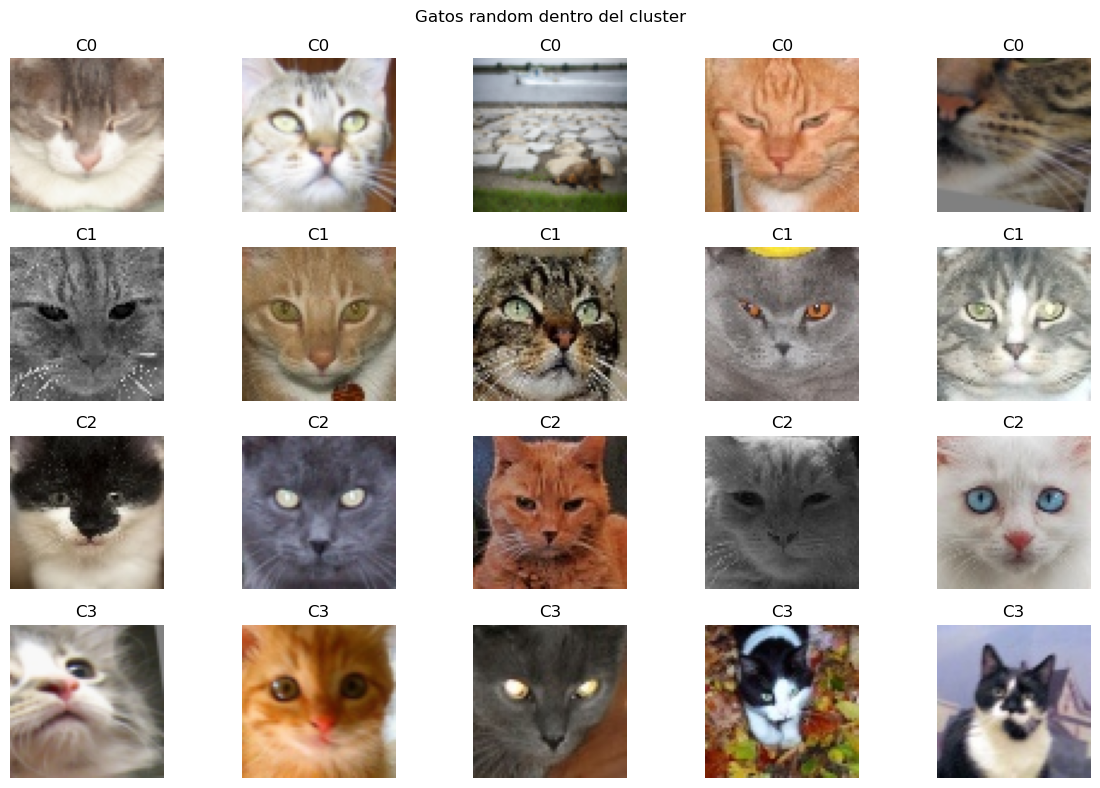

In [134]:
fig, axs = plt.subplots(4, 5, figsize=(12, 2*4))
axs = axs.reshape(4, 5)

for cluster_id in range(4):
    idxs = np.where(labels == cluster_id)[0]
    selected = random.sample(list(idxs), min(5, len(idxs)))

    for j, img_idx in enumerate(selected):
        axs[cluster_id, j].imshow(original_images[img_idx])
        axs[cluster_id, j].axis('off')
        axs[cluster_id, j].set_title(f"C{cluster_id}")

plt.suptitle("Gatos random dentro del cluster")
plt.tight_layout()
plt.show()

<p>Que opinan de la asociación que realizo el aalgoritmo, que otra metrica de similitud podriamos usar?, Se nota algo?</p>

## Clustering Jerarquico

In [135]:
X_data = X_pca 

In [136]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                count += 1
            else:
                count += counts[child_idx - n_samples]
        counts[i] = count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

In [137]:
model = AgglomerativeClustering(
    distance_threshold=0,  
    n_clusters=None,
    linkage='ward',        
    affinity='euclidean'  
)
model = model.fit(X_data)

c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


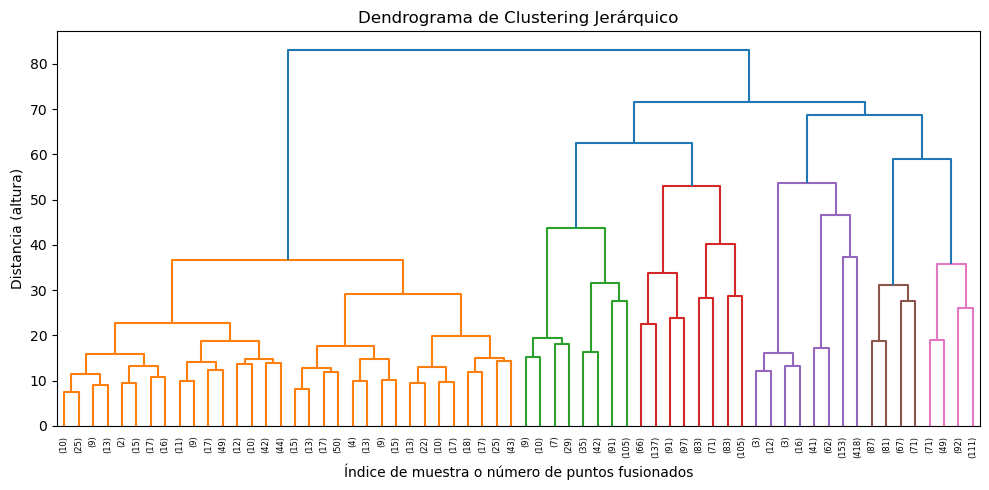

In [138]:
plt.figure(figsize=(10, 5))
plt.title("Dendrograma de Clustering Jerárquico")
plot_dendrogram(model, truncate_mode="level", p=5)
plt.xlabel("Índice de muestra o número de puntos fusionados");plt.ylabel("Distancia (altura)")
plt.grid(False)
plt.tight_layout()
plt.show()

In [139]:
model = AgglomerativeClustering(n_clusters=4, linkage='complete', affinity='cosine')
labels = model.fit_predict(X_data)

c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


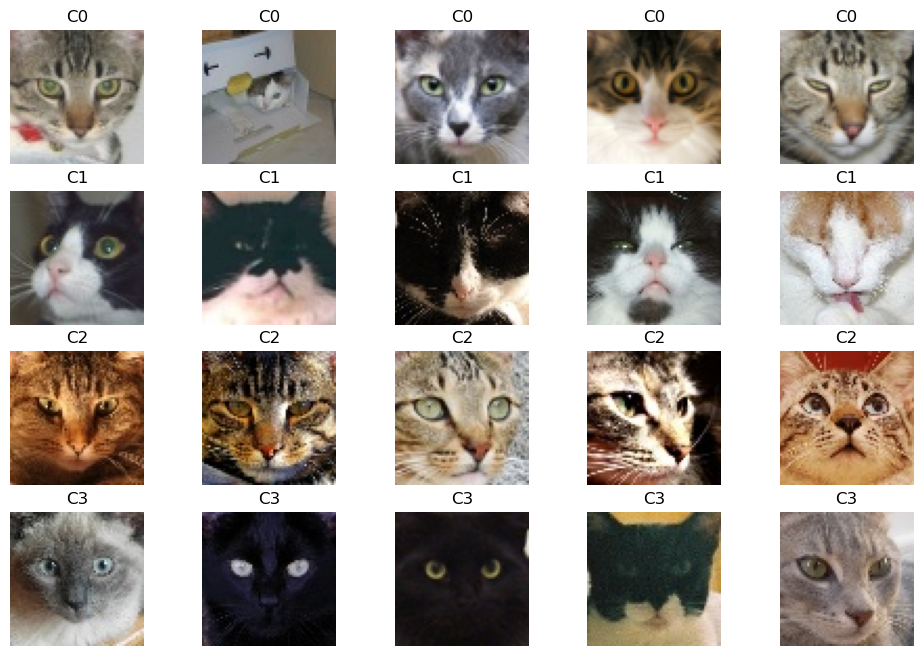

In [140]:
fig, axs = plt.subplots(4, 5, figsize=(12, 2*4))
axs = axs.reshape(4, 5)

for cluster_id in range(4):
    idxs = np.where(labels == cluster_id)[0]
    selected = random.sample(list(idxs), min(5, len(idxs)))

    for j in range(5):
        axs[cluster_id, j].axis('off')  

        if j < len(selected):
            img_idx = selected[j]
            axs[cluster_id, j].imshow(original_images[img_idx])
            axs[cluster_id, j].set_title(f"C{cluster_id}")